# IMPORT THE LIBRARIES

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# IMPORTING THE DATASET

In [6]:
data = pd.read_excel(r"/content/COPPD.xlsx")

In [7]:
data.head()


,Date,Closing Value
0,1986-01-02,25.56
1,1986-01-03,26.00
2,1986-01-06,26.53
3,1986-01-07,25.85
4,1986-01-08,25.87


# HANDLING MISSING DATA

In [8]:
data.isnull().any()

Date             False
Closing Value     True
dtype: bool

In [9]:
data.isnull().sum()

Date             0
Closing Value    7
dtype: int64

In [10]:
data.dropna(axis=0,inplace=True)
data.isnull().sum()

Date             0
Closing Value    0
dtype: int64

In [11]:
data_oil=data.reset_index()['Closing Value']
data_oil


0       25.56
1       26.00
2       26.53
3       25.85
4       25.87
        ...  
8211    73.89
8212    74.19
8213    73.05
8214    73.78
8215    73.93
Name: Closing Value, Length: 8216, dtype: float64

# FEATURE SCALING

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
data_oil=scaler.fit_transform(np.array(data_oil).reshape(-1,1))

In [13]:
data_oil

array([[0.11335703],
       [0.11661484],
       [0.12053902],
       ...,
       [0.46497853],
       [0.47038353],
       [0.47149415]])

# DATA VISUALIZATION

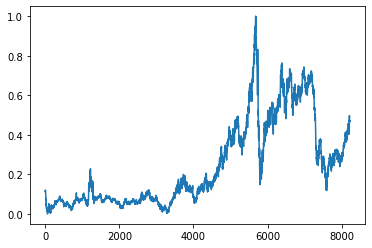

In [14]:
plt.plot(data_oil)

# SPLITTING DATA INTO TRAIN AND TEST

In [15]:
training_size=int(len(data_oil)*0.65)
test_size=len(data_oil)-training_size
train_data,test_data=data_oil[0:training_size,:],data_oil[training_size:len(data_oil),:1]

In [16]:
training_size,test_size

(5340, 2876)

In [17]:
train_data.shape

(5340, 1)

# CREATING A DATASET WITH SLIDING WINDOWS

In [18]:
def create_dataset(dataset,time_step=1):
  dataX,dataY=[],[]
  for i in range(len(dataset)-time_step-1):
    a=dataset[i:(i+time_step),0]
    dataX.append(a)
    dataY.append(dataset[i+time_step,0])
  return np.array(dataX),np.array(dataY)

In [19]:
time_step=10
x_train,y_train=create_dataset(train_data,time_step)
x_test,y_test=create_dataset(test_data,time_step)

In [20]:
print(x_train.shape),print(y_train.shape)

(5329, 10)
(5329,)


(None, None)

In [21]:
print(x_test.shape),print(y_test.shape)

(2865, 10)
(2865,)


(None, None)

In [22]:
x_train

array([[0.11335703, 0.11661484, 0.12053902, ..., 0.10980305, 0.1089886 ,
        0.11054346],
       [0.11661484, 0.12053902, 0.11550422, ..., 0.1089886 , 0.11054346,
        0.10165852],
       [0.12053902, 0.11550422, 0.1156523 , ..., 0.11054346, 0.10165852,
        0.09906708],
       ...,
       [0.36731823, 0.35176958, 0.36080261, ..., 0.36391234, 0.37042796,
        0.37042796],
       [0.35176958, 0.36080261, 0.35354657, ..., 0.37042796, 0.37042796,
        0.37879461],
       [0.36080261, 0.35354657, 0.35295424, ..., 0.37042796, 0.37879461,
        0.37916482]])

In [23]:
x_train=x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],1)

# IMPORTING THE MODEL BUILDING LIBRARIES

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

# INITIALIZING THE MODEL

In [25]:
model=Sequential()

# ADDING LSTM LAYERS

In [26]:
model.add(LSTM(50,return_sequences=True,input_shape=(10,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))

# ADDING OUTPUT LAYERS

In [27]:
model.add(Dense(1))

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 10, 50)            20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


# CONFIGURE THE LEARNING PROCESS

In [29]:
model.compile(loss='mean_squared_error',optimizer='adam')

# TRAIN THE MODEL

model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=3,batch_size=64,verbose=1)

# MODEL EVALUATION

In [30]:
train_predict=scaler.inverse_transform(train_data) 
test_predict=scaler.inverse_transform(test_data)
### Calculate RMSE performance metrics
import math 
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(train_data,train_predict))

29.347830443269938

# SAVE THE MODEL

In [31]:
from tensorflow.keras.models import load_model

In [32]:
model.save("crude_oil.hs")

# TEST THE MODEL

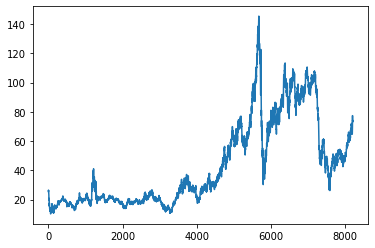

In [33]:
### Plotting
look_back=10
trainpredictPlot = np.empty_like(data_oil)
trainpredictPlot[:, :]= np.nan
trainpredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictplot = np.empty_like(data_oil)
testPredictplot[:,: ] = np.nan
testPredictplot[look_back:len(test_predict)+look_back, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(data_oil))
plt.show()

In [34]:
len(test_data)

2876

In [35]:
x_input=test_data[2866:].reshape(1,-1)
x_input.shape

(1, 10)

In [36]:
temp_input=list(x_input) 
temp_input=temp_input[0].tolist()
temp_input

[0.44172960165852215,
 0.48111950244335855,
 0.49726047682511476,
 0.4679401747371539,
 0.4729749740855915,
 0.47119798608026064,
 0.47341922108692425,
 0.4649785280616022,
 0.4703835332444839,
 0.47149415074781587]

In [37]:
lst_output=[]
n_steps=10
i=0
while(i<10):
    if(len(temp_input)>10):
#print(temp_input)
       x_input=np.array(temp_input[1:]) 
       print("{} day input {}".format(i,x_input))
       x_input=x_input.reshape(1,-1)
       x_input = x_input.reshape((1, n_steps, 1)) #print(x_input)
       yhat = model.predict(x_input, verbose=0)
       print("{} day output {}".format(i,yhat))
       temp_input.extend(yhat[0].tolist())
       temp_input=temp_input[1:] #print(temp_input)
       lst_output.extend(yhat.tolist())
       i=i+1
    else:
       x_input = x_input.reshape((1, n_steps,1))
       yhat = model.predict(x_input, verbose=0)
       print(yhat[0])
       temp_input.extend(yhat[0].tolist()) 
       print(len(temp_input))
       lst_output.extend(yhat.tolist())
       i=i+1

[-0.02099573]
11
1 day input [ 0.4811195   0.49726048  0.46794017  0.47297497  0.47119799  0.47341922
  0.46497853  0.47038353  0.47149415 -0.02099573]
1 day output [[-0.0205557]]
2 day input [ 0.49726048  0.46794017  0.47297497  0.47119799  0.47341922  0.46497853
  0.47038353  0.47149415 -0.02099573 -0.0205557 ]
2 day output [[-0.01924895]]
3 day input [ 0.46794017  0.47297497  0.47119799  0.47341922  0.46497853  0.47038353
  0.47149415 -0.02099573 -0.0205557  -0.01924895]
3 day output [[-0.01722219]]
4 day input [ 0.47297497  0.47119799  0.47341922  0.46497853  0.47038353  0.47149415
 -0.02099573 -0.0205557  -0.01924895 -0.01722219]
4 day output [[-0.01479625]]
5 day input [ 0.47119799  0.47341922  0.46497853  0.47038353  0.47149415 -0.02099573
 -0.0205557  -0.01924895 -0.01722219 -0.01479625]
5 day output [[-0.0120291]]
6 day input [ 0.47341922  0.46497853  0.47038353  0.47149415 -0.02099573 -0.0205557
 -0.01924895 -0.01722219 -0.01479625 -0.0120291 ]
6 day output [[-0.00914845]]
7 

In [38]:
day_new=np.arange(1,11) 
day_pred=np.arange(11,21)
len(data_oil)

8216

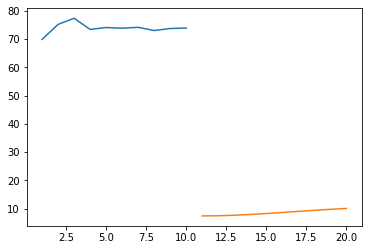

In [39]:
plt.plot(day_new, scaler.inverse_transform(data_oil[8206:])) 
plt.plot(day_pred, scaler.inverse_transform(lst_output))

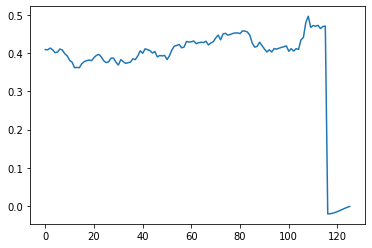

In [40]:
df3=data_oil.tolist() 
df3.extend(lst_output) 
plt.plot(df3[8100:])

In [41]:
df3=scaler.inverse_transform(df3).tolist()

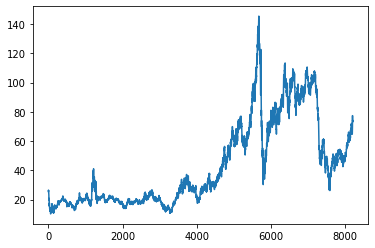

In [42]:
plt.plot(scaler.inverse_transform(data_oil))